In [1]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, ConstAct, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs, observe_total

# Finding optimal fixed policies for several cases to explore in the paper
---
## Setup

In [2]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    if ray.is_initialized():
        ray.shutdown()
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

In [3]:
msy_space = [Real(0.001, 0.25, name='mortality')]
esc_space = [Real(0, AsmEnv().bound / 5, name='escapement')]
cr_space  = [
    Real(-5, 2, name='log_radius'),
    Real(- np.pi/4.00001, np.pi/4.00001, name='theta'),
    Real(0, 0.3, name='y2'),
]
def msy_obj_generator(config):
    @use_named_args(msy_space)
    def msy_obj(**x):
        eval_env = AsmEnv(config=config)
        agent = Msy(env=eval_env, mortality = x['mortality'])
        rews = eval_pol(
            policy=agent, 
            env_cls=AsmEnv, config=config, 
            n_batches=1, batch_size=200
        )
        return -np.mean(rews)
    return msy_obj

def esc_obj_generator(config):
    @use_named_args(esc_space)
    def esc_obj(**x):
        eval_env = AsmEnv(config=config)
        agent = ConstEsc(env=eval_env, escapement = x['escapement'])
        rews = eval_pol(
            policy=agent, 
            env_cls=AsmEnv, config=config, 
            n_batches=1, batch_size=200
        )
        return -np.mean(rews)
    return esc_obj

def cr_obj_generator(config):
    @use_named_args(cr_space)
    def cr_obj(**x):
        theta = x["theta"]
        radius = 10 ** x["log_radius"]
        x1 = np.sin(theta) * radius
        x2 = np.cos(theta) * radius
        #
        eval_env = AsmEnv(config=config)
        eval_env.reset()
        agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
        rews = eval_pol(
            policy=agent, 
            env_cls=AsmEnv, 
            config=config, 
            n_batches=1, batch_size=200
        )
        return -np.mean(rews)
    return cr_obj

In [4]:
NCALLS = 40

## upow=1, trophy fishing 10 age classes

In [5]:
CONFIG3 = {
    "upow": 1,
    "harvest_fn_name": "trophy"
}

cr_obj3 = cr_obj_generator(CONFIG3)
esc_obj3 = esc_obj_generator(CONFIG3)
msy_obj3 = msy_obj_generator(CONFIG3)

In [9]:
%%time

cr_gp3 = gp_minimize(cr_obj3, cr_space, n_calls = NCALLS, verbose=True)
print("\n--------------------"*2)
esc_gp3 = gp_minimize(esc_obj3, esc_space, n_calls = NCALLS, verbose=True)
print("\n--------------------"*2)
msy_gp3 = gp_minimize(msy_obj3, msy_space, n_calls = NCALLS, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


2024-05-24 19:11:25,183	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.4516
Function value obtained: -3.1997
Current minimum: -3.1997
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 19:11:33,630	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.7052
Function value obtained: -6.5283
Current minimum: -6.5283
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 19:11:41,351	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.4599
Function value obtained: -22.9527
Current minimum: -22.9527
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 19:11:49,814	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.7430
Function value obtained: -26.7393
Current minimum: -26.7393
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 19:11:57,583	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.7411
Function value obtained: -6.7580
Current minimum: -26.7393
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 19:12:05,291	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 8.4607
Function value obtained: -0.0109
Current minimum: -26.7393
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 19:12:13,770	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 8.1181
Function value obtained: -4.8319
Current minimum: -26.7393
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 19:12:21,893	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.6239
Function value obtained: -1.9565
Current minimum: -26.7393
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 19:12:30,602	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 8.5311
Function value obtained: -0.5830
Current minimum: -26.7393
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 19:12:39,051	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 8.9081
Function value obtained: -16.4910
Current minimum: -26.7393
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 19:12:47,965	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.8131
Function value obtained: -27.9997
Current minimum: -27.9997
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 19:12:56,768	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.7463
Function value obtained: -28.4467
Current minimum: -28.4467
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 19:13:05,517	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.7956
Function value obtained: -27.3375
Current minimum: -28.4467
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 19:13:14,292	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.7755
Function value obtained: -14.2261
Current minimum: -28.4467
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 19:13:23,065	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.8205
Function value obtained: -28.2476
Current minimum: -28.4467
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 19:13:31,916	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.0165
Function value obtained: -26.4324
Current minimum: -28.4467
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 19:13:40,921	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.7226
Function value obtained: -0.0000
Current minimum: -28.4467
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 19:13:49,679	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.7945
Function value obtained: -0.0000
Current minimum: -28.4467
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 19:13:58,484	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 8.7617
Function value obtained: -29.7365
Current minimum: -29.7365
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 19:14:07,223	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.8635
Function value obtained: -28.8264
Current minimum: -29.7365
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 19:14:16,093	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 8.8558
Function value obtained: -30.5688
Current minimum: -30.5688
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 19:14:24,959	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.3566
Function value obtained: -31.3171
Current minimum: -31.3171
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 19:14:33,327	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.0471
Function value obtained: -30.8064
Current minimum: -31.3171
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 19:14:41,383	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 8.1063
Function value obtained: -21.6612
Current minimum: -31.3171
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 19:14:49,515	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.9988
Function value obtained: -29.9731
Current minimum: -31.3171
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 19:14:58,523	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.9511
Function value obtained: -29.6215
Current minimum: -31.3171
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 19:15:07,462	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.1322
Function value obtained: -31.4150
Current minimum: -31.4150
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 19:15:16,590	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.9694
Function value obtained: -31.1333
Current minimum: -31.4150
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 19:15:25,570	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.9227
Function value obtained: -6.5397
Current minimum: -31.4150
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 19:15:34,515	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 8.8802
Function value obtained: -31.7101
Current minimum: -31.7101
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 19:15:43,379	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 8.9249
Function value obtained: -31.6148
Current minimum: -31.7101
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 19:15:53,303	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 9.9819
Function value obtained: -31.3555
Current minimum: -31.7101
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 19:16:02,334	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 8.7532
Function value obtained: -0.0000
Current minimum: -31.7101
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 19:16:11,055	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 8.9633
Function value obtained: -30.7369
Current minimum: -31.7101
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 19:16:20,017	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 8.9807
Function value obtained: -0.0000
Current minimum: -31.7101
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 19:16:28,992	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 8.9359
Function value obtained: -0.0000
Current minimum: -31.7101
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 19:16:37,929	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 9.0881
Function value obtained: -31.3828
Current minimum: -31.7101
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 19:16:47,050	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.0722
Function value obtained: -1.1221
Current minimum: -31.7101
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 19:16:56,131	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 10.1829
Function value obtained: -31.1595
Current minimum: -31.7101
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 19:17:06,317	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.1643
Function value obtained: -31.2598
Current minimum: -31.7101

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-24 19:17:15,484	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.7507
Function value obtained: -2.5989
Current minimum: -2.5989
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 19:17:24,295	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.7705
Function value obtained: -13.7095
Current minimum: -13.7095
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 19:17:33,095	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.8140
Function value obtained: -11.9370
Current minimum: -13.7095
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 19:17:41,861	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.3590
Function value obtained: -6.7621
Current minimum: -13.7095
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 19:17:50,270	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.8122
Function value obtained: -9.9579
Current minimum: -13.7095
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 19:17:59,042	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 8.6047
Function value obtained: -0.0816
Current minimum: -13.7095
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 19:18:07,689	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 8.8067
Function value obtained: -1.1403
Current minimum: -13.7095
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 19:18:16,473	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.7715
Function value obtained: -12.6753
Current minimum: -13.7095
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 19:18:25,270	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 8.7691
Function value obtained: -0.7091
Current minimum: -13.7095
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 19:18:34,041	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 9.2388
Function value obtained: -1.5970
Current minimum: -13.7095
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 19:18:43,243	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.0674
Function value obtained: -13.7622
Current minimum: -13.7622
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 19:18:52,295	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.6153
Function value obtained: -13.2632
Current minimum: -13.7622
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 19:19:01,000	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.0366
Function value obtained: -13.0581
Current minimum: -13.7622
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 19:19:10,046	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 9.6125
Function value obtained: -0.0604
Current minimum: -13.7622
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 19:19:19,610	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.3962
Function value obtained: -13.8986
Current minimum: -13.8986
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 19:19:29,061	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.3479
Function value obtained: -13.3746
Current minimum: -13.8986
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 19:19:38,356	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.6922
Function value obtained: -12.8879
Current minimum: -13.8986
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 19:19:47,080	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.1179
Function value obtained: -13.4850
Current minimum: -13.8986
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 19:19:56,195	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.0332
Function value obtained: -13.4547
Current minimum: -13.8986
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 19:20:05,227	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.0526
Function value obtained: -13.3495
Current minimum: -13.8986
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 19:20:14,258	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.0562
Function value obtained: -0.2710
Current minimum: -13.8986
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 19:20:23,357	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.2721
Function value obtained: -13.5180
Current minimum: -13.8986
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 19:20:32,636	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.2449
Function value obtained: -13.4055
Current minimum: -13.8986
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 19:20:41,911	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.0993
Function value obtained: -13.9822
Current minimum: -13.9822
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 19:20:50,937	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.0729
Function value obtained: -13.2498
Current minimum: -13.9822
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 19:21:00,020	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.2779
Function value obtained: -13.4668
Current minimum: -13.9822
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 19:21:10,320	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.4320
Function value obtained: -13.4532
Current minimum: -13.9822
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 19:21:19,748	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 9.5455
Function value obtained: -13.1296
Current minimum: -13.9822
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 19:21:29,312	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.2624
Function value obtained: -13.3584
Current minimum: -13.9822
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 19:21:38,625	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.1221
Function value obtained: -12.4933
Current minimum: -13.9822
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 19:21:48,713	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.1819
Function value obtained: -13.2568
Current minimum: -13.9822
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 19:21:57,916	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 8.7738
Function value obtained: -13.2592
Current minimum: -13.9822
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 19:22:06,642	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 9.4649
Function value obtained: -13.5029
Current minimum: -13.9822
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 19:22:16,166	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.1748
Function value obtained: -13.6450
Current minimum: -13.9822
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 19:22:25,332	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.2320
Function value obtained: -12.8053
Current minimum: -13.9822
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 19:22:34,628	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.2320
Function value obtained: -12.8431
Current minimum: -13.9822
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 19:22:43,888	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 9.8065
Function value obtained: -13.9130
Current minimum: -13.9822
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 19:22:53,601	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.1979
Function value obtained: -13.3716
Current minimum: -13.9822
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 19:23:03,794	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 10.1941
Function value obtained: -13.5835
Current minimum: -13.9822
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 19:23:12,961	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.3120
Function value obtained: -12.9922
Current minimum: -13.9822

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-24 19:23:22,354	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.2445
Function value obtained: -2.8234
Current minimum: -2.8234
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 19:23:31,648	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.5994
Function value obtained: -3.8033
Current minimum: -3.8033
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 19:23:41,195	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.6936
Function value obtained: -1.7693
Current minimum: -3.8033
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 19:23:50,848	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.0173
Function value obtained: -10.7400
Current minimum: -10.7400
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 19:23:59,928	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 9.5029
Function value obtained: -4.5722
Current minimum: -10.7400
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 19:24:09,962	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 9.8481
Function value obtained: -24.1916
Current minimum: -24.1916
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 19:24:19,279	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 9.0514
Function value obtained: -2.3565
Current minimum: -24.1916
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 19:24:28,437	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 10.0270
Function value obtained: -6.1845
Current minimum: -24.1916
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 19:24:38,375	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 9.3369
Function value obtained: -19.4562
Current minimum: -24.1916
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 19:24:47,634	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 9.2591
Function value obtained: -23.4271
Current minimum: -24.1916
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 19:24:56,952	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 9.0426
Function value obtained: -1.3370
Current minimum: -24.1916
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 19:25:06,027	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 10.9825
Function value obtained: -24.1701
Current minimum: -24.1916
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 19:25:17,010	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.7463
Function value obtained: -23.5009
Current minimum: -24.1916
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 19:25:26,729	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 9.3757
Function value obtained: -24.3974
Current minimum: -24.3974
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 19:25:36,163	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.3587
Function value obtained: -23.9335
Current minimum: -24.3974
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 19:25:45,524	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.1368
Function value obtained: -24.2812
Current minimum: -24.3974
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 19:25:54,684	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.3667
Function value obtained: -23.7564
Current minimum: -24.3974
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 19:26:05,077	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.3228
Function value obtained: -24.0885
Current minimum: -24.3974
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 19:26:14,409	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.4847
Function value obtained: -1.4339
Current minimum: -24.3974
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 19:26:23,892	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.4311
Function value obtained: -22.5492
Current minimum: -24.3974
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 19:26:33,288	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.4446
Function value obtained: -24.1125
Current minimum: -24.3974
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 19:26:42,735	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.8582
Function value obtained: -24.9897
Current minimum: -24.9897
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 19:26:52,597	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.5239
Function value obtained: -24.3544
Current minimum: -24.9897
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 19:27:02,131	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.5923
Function value obtained: -24.7287
Current minimum: -24.9897
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 19:27:11,732	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.7160
Function value obtained: -25.5449
Current minimum: -25.5449
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 19:27:21,440	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.0578
Function value obtained: -24.2661
Current minimum: -25.5449
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 19:27:31,518	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 11.0957
Function value obtained: -23.8934
Current minimum: -25.5449
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 19:27:42,609	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.4367
Function value obtained: -24.8825
Current minimum: -25.5449
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 19:27:53,047	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 9.5060
Function value obtained: -25.2361
Current minimum: -25.5449
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 19:28:02,591	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 9.4736
Function value obtained: -24.0366
Current minimum: -25.5449
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 19:28:12,059	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.4649
Function value obtained: -25.2479
Current minimum: -25.5449
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 19:28:22,539	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 11.1297
Function value obtained: -24.3826
Current minimum: -25.5449
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 19:28:32,723	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 9.4881
Function value obtained: -25.3757
Current minimum: -25.5449
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 19:28:42,184	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.4984
Function value obtained: -24.6935
Current minimum: -25.5449
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 19:28:51,719	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.5176
Function value obtained: -24.6567
Current minimum: -25.5449
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 19:29:01,227	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.9622
Function value obtained: -24.5985
Current minimum: -25.5449
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 19:29:11,197	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 9.6649
Function value obtained: -23.9832
Current minimum: -25.5449
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 19:29:20,844	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 10.2147
Function value obtained: -24.7094
Current minimum: -25.5449
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 19:29:31,064	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 10.0227
Function value obtained: -24.4611
Current minimum: -25.5449
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 19:29:41,110	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 9.7620
Function value obtained: -24.3058
Current minimum: -25.5449
CPU times: user 14min 51s, sys: 19min 45s, total: 34min 37s
Wall time: 18min 25s


In [14]:
# plot_objective(esc_gp3) # looks good!

In [15]:
print(f"""
cr.: {cr_gp3.fun:.2f}, {cr_gp3.x} 
esc: {esc_gp3.fun:.2f}, {esc_gp3.x}
msy: {msy_gp3.fun:.2f}, {msy_gp3.x}
""")


cr.: -31.71, [-0.2958516511636784, 0.4446492829229163, 0.08970008331564934] 
esc: -13.98, [1.136737379993107]
msy: -25.54, [0.04672528295535901]



## upow=0.6, non-trophy fishing

In [16]:
CONFIG1 = {
    "upow": 0.6
}

cr_obj1 = cr_obj_generator(CONFIG1)
esc_obj1 = esc_obj_generator(CONFIG1)
msy_obj1 = msy_obj_generator(CONFIG1)

In [17]:
%%time

cr_gp1 = gp_minimize(cr_obj1, cr_space, n_calls = NCALLS, verbose=True)
print("\n--------------------"*2)
esc_gp1 = gp_minimize(esc_obj1, esc_space, n_calls = NCALLS, verbose=True)
print("\n--------------------"*2)
msy_gp1 = gp_minimize(msy_obj1, msy_space, n_calls = NCALLS, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.5186
Function value obtained: -10.2335
Current minimum: -10.2335
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 19:31:13,215	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.1620
Function value obtained: -24.2906
Current minimum: -24.2906
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 19:31:22,540	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.4016
Function value obtained: -9.4887
Current minimum: -24.2906
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 19:31:32,044	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.6123
Function value obtained: -136.8509
Current minimum: -136.8509
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 19:31:41,557	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.2846
Function value obtained: -8.0572
Current minimum: -136.8509
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 19:31:51,777	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 10.2745
Function value obtained: -133.5202
Current minimum: -136.8509
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 19:32:02,095	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 9.7550
Function value obtained: -61.5989
Current minimum: -136.8509
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 19:32:11,799	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.1711
Function value obtained: -34.3222
Current minimum: -136.8509
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 19:32:21,037	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 9.8201
Function value obtained: -110.6454
Current minimum: -136.8509
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 19:32:30,843	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 10.1430
Function value obtained: -100.4184
Current minimum: -136.8509
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 19:32:41,005	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.4935
Function value obtained: -0.0000
Current minimum: -136.8509
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 19:32:51,656	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 10.0505
Function value obtained: -128.8594
Current minimum: -136.8509
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 19:33:01,538	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.4755
Function value obtained: -139.4282
Current minimum: -139.4282
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 19:33:11,073	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.7018
Function value obtained: -138.0903
Current minimum: -139.4282
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 19:33:22,622	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 13.6099
Function value obtained: -146.0186
Current minimum: -146.0186
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 19:33:33,336	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 10.9004
Function value obtained: -149.7063
Current minimum: -149.7063
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 19:33:44,268	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.6152
Function value obtained: -148.2921
Current minimum: -149.7063
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 19:33:53,845	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 10.3368
Function value obtained: -0.0000
Current minimum: -149.7063
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 19:34:04,182	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.5271
Function value obtained: -149.1930
Current minimum: -149.7063
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 19:34:13,860	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.0119
Function value obtained: -150.1250
Current minimum: -150.1250
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 19:34:23,785	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.9642
Function value obtained: -150.0871
Current minimum: -150.1250
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 19:34:33,704	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.6005
Function value obtained: -146.4708
Current minimum: -150.1250
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 19:34:43,333	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 10.0960
Function value obtained: -146.3879
Current minimum: -150.1250
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 19:34:53,444	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.6909
Function value obtained: -145.2411
Current minimum: -150.1250
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 19:35:03,123	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.8158
Function value obtained: -126.8413
Current minimum: -150.1250
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 19:35:12,973	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.9763
Function value obtained: -119.4992
Current minimum: -150.1250
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 19:35:22,948	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.0881
Function value obtained: -146.5926
Current minimum: -150.1250
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 19:35:33,027	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.4038
Function value obtained: -146.1494
Current minimum: -150.1250
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 19:35:43,507	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.6138
Function value obtained: -0.0000
Current minimum: -150.1250
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 19:35:54,054	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.2692
Function value obtained: -145.8938
Current minimum: -150.1250
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 19:36:04,369	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 10.0923
Function value obtained: -0.0000
Current minimum: -150.1250
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 19:36:14,489	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 9.8600
Function value obtained: -128.3500
Current minimum: -150.1250
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 19:36:24,311	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 10.2425
Function value obtained: -143.7077
Current minimum: -150.1250
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 19:36:34,594	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 10.2733
Function value obtained: -0.0000
Current minimum: -150.1250
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 19:36:44,811	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 10.4232
Function value obtained: -144.4944
Current minimum: -150.1250
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 19:36:55,236	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 10.0153
Function value obtained: -123.5602
Current minimum: -150.1250
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 19:37:05,332	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 10.9372
Function value obtained: -97.4335
Current minimum: -150.1250
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 19:37:17,260	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 12.0363
Function value obtained: -132.8630
Current minimum: -150.1250
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 19:37:28,270	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 12.8358
Function value obtained: -22.1397
Current minimum: -150.1250
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 19:37:41,194	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 10.2494
Function value obtained: -135.8170
Current minimum: -150.1250

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-24 19:37:51,412	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.1063
Function value obtained: -2.3129
Current minimum: -2.3129
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 19:38:02,628	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.9156
Function value obtained: -0.1582
Current minimum: -2.3129
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 19:38:12,422	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.6119
Function value obtained: -0.1828
Current minimum: -2.3129
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 19:38:22,080	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.5967
Function value obtained: -1.0969
Current minimum: -2.3129
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 19:38:31,740	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.6148
Function value obtained: -0.4385
Current minimum: -2.3129
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 19:38:42,306	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 9.8437
Function value obtained: -0.4405
Current minimum: -2.3129
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 19:38:52,204	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 10.9900
Function value obtained: -95.7194
Current minimum: -95.7194
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 19:39:03,118	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 10.1492
Function value obtained: -33.4026
Current minimum: -95.7194
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 19:39:13,368	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 10.2079
Function value obtained: -0.1904
Current minimum: -95.7194
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 19:39:23,486	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 10.2832
Function value obtained: -0.0817
Current minimum: -95.7194
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 19:39:33,761	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.6636
Function value obtained: -107.4204
Current minimum: -107.4204
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 19:39:44,504	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.8027
Function value obtained: -2.6271
Current minimum: -107.4204
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 19:39:54,398	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.7279
Function value obtained: -106.1368
Current minimum: -107.4204
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 19:40:07,348	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 14.6205
Function value obtained: -103.0969
Current minimum: -107.4204
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 19:40:17,666	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 10.2602
Function value obtained: -109.3642
Current minimum: -109.3642
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 19:40:27,913	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.1735
Function value obtained: -109.4980
Current minimum: -109.4980
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 19:40:40,849	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 12.5517
Function value obtained: -104.1693
Current minimum: -109.4980
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 19:40:54,005	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 14.4668
Function value obtained: -76.1099
Current minimum: -109.4980
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 19:41:04,130	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 10.8885
Function value obtained: -8.9258
Current minimum: -109.4980
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 19:41:15,020	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.5906
Function value obtained: -57.0804
Current minimum: -109.4980
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 19:41:25,603	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 10.5209
Function value obtained: -4.0593
Current minimum: -109.4980
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 19:41:36,155	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.9820
Function value obtained: -110.5932
Current minimum: -110.5932
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 19:41:49,334	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 15.2155
Function value obtained: -108.4352
Current minimum: -110.5932
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 19:42:00,386	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.0849
Function value obtained: -18.3594
Current minimum: -110.5932
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 19:42:10,464	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 10.6497
Function value obtained: -107.9916
Current minimum: -110.5932
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 19:42:21,107	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.1949
Function value obtained: -109.1506
Current minimum: -110.5932
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 19:42:31,331	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 9.4586
Function value obtained: -106.9728
Current minimum: -110.5932
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 19:42:45,778	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 15.8136
Function value obtained: -90.5518
Current minimum: -110.5932
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 19:42:56,684	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.9237
Function value obtained: -110.2055
Current minimum: -110.5932
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 19:43:07,587	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 11.0950
Function value obtained: -105.5405
Current minimum: -110.5932
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 19:43:18,655	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 10.8020
Function value obtained: -110.0656
Current minimum: -110.5932
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 19:43:29,440	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 11.5400
Function value obtained: -111.6948
Current minimum: -111.6948
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 19:43:41,027	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 11.0360
Function value obtained: -108.2348
Current minimum: -111.6948
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 19:43:52,051	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 10.5317
Function value obtained: -45.0164
Current minimum: -111.6948
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 19:44:02,574	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 11.5652
Function value obtained: -111.1728
Current minimum: -111.6948
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 19:44:14,094	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 11.6510
Function value obtained: -107.1987
Current minimum: -111.6948
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 19:44:25,830	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 14.5112
Function value obtained: -106.5132
Current minimum: -111.6948
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 19:44:40,315	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 10.2311
Function value obtained: -107.8871
Current minimum: -111.6948
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 19:44:50,602	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 9.6303
Function value obtained: -109.5860
Current minimum: -111.6948
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 19:45:00,900	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 12.3379
Function value obtained: -108.2855
Current minimum: -111.6948

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-24 19:45:12,488	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.9504
Function value obtained: -12.7125
Current minimum: -12.7125
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 19:45:22,516	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.1196
Function value obtained: -11.5940
Current minimum: -12.7125
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 19:45:32,658	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.3079
Function value obtained: -32.8462
Current minimum: -32.8462
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 19:45:43,957	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.5472
Function value obtained: -105.7970
Current minimum: -105.7970
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 19:45:54,508	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.7245
Function value obtained: -34.5301
Current minimum: -105.7970
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 19:46:06,243	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.1340
Function value obtained: -114.0690
Current minimum: -114.0690
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 19:46:18,214	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 12.7205
Function value obtained: -65.3205
Current minimum: -114.0690
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 19:46:29,106	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 10.3345
Function value obtained: -8.5293
Current minimum: -114.0690
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 19:46:39,441	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.5117
Function value obtained: -46.7897
Current minimum: -114.0690
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 19:46:51,989	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.3599
Function value obtained: -9.6972
Current minimum: -114.0690
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 19:47:03,272	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.9172
Function value obtained: -124.8926
Current minimum: -124.8926
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 19:47:15,230	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.1081
Function value obtained: -121.5150
Current minimum: -124.8926
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 19:47:26,340	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 11.3430
Function value obtained: -124.2937
Current minimum: -124.8926
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 19:47:37,695	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 10.3123
Function value obtained: -122.6365
Current minimum: -124.8926
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 19:47:48,015	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.0860
Function value obtained: -122.9173
Current minimum: -124.8926
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 19:48:01,378	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 14.9621
Function value obtained: -122.6017
Current minimum: -124.8926
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 19:48:12,080	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.1725
Function value obtained: -122.9132
Current minimum: -124.8926
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 19:48:25,745	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 15.3665
Function value obtained: -122.0319
Current minimum: -124.8926
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 19:48:36,655	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 10.3742
Function value obtained: -124.4707
Current minimum: -124.8926
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 19:48:47,009	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.8190
Function value obtained: -127.3040
Current minimum: -127.3040
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 19:48:57,792	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 11.0690
Function value obtained: -125.3524
Current minimum: -127.3040
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 19:49:08,958	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 11.4150
Function value obtained: -122.2632
Current minimum: -127.3040
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 19:49:20,367	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.2634
Function value obtained: -118.9392
Current minimum: -127.3040
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 19:49:35,237	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 16.3303
Function value obtained: -120.4615
Current minimum: -127.3040
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 19:49:45,932	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.2637
Function value obtained: -125.3327
Current minimum: -127.3040
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 19:50:00,162	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 16.1308
Function value obtained: -122.4334
Current minimum: -127.3040
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 19:50:11,380	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.9672
Function value obtained: -124.4445
Current minimum: -127.3040
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 19:50:22,281	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.8215
Function value obtained: -125.8148
Current minimum: -127.3040
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 19:50:33,156	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.2420
Function value obtained: -126.8922
Current minimum: -127.3040
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 19:50:44,559	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 12.9081
Function value obtained: -122.7065
Current minimum: -127.3040
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 19:50:56,297	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 10.7134
Function value obtained: -121.7051
Current minimum: -127.3040
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 19:51:07,071	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 12.6497
Function value obtained: -123.0796
Current minimum: -127.3040
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 19:51:19,709	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 10.9608
Function value obtained: -121.6733
Current minimum: -127.3040
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 19:51:30,650	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 11.5136
Function value obtained: -125.8669
Current minimum: -127.3040
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 19:51:42,172	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 12.1153
Function value obtained: -125.0135
Current minimum: -127.3040
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 19:51:54,351	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 10.7594
Function value obtained: -122.2269
Current minimum: -127.3040
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 19:52:05,072	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 11.0589
Function value obtained: -121.1210
Current minimum: -127.3040
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 19:52:16,158	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 10.9067
Function value obtained: -124.1935
Current minimum: -127.3040
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 19:52:27,133	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 12.0283
Function value obtained: -124.4234
Current minimum: -127.3040
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 19:52:39,144	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 16.1896
Function value obtained: -120.8218
Current minimum: -127.3040
CPU times: user 15min 14s, sys: 19min 8s, total: 34min 22s
Wall time: 21min 47s


In [18]:
print(f"""
cr.: {cr_gp1.fun:.2f}, {cr_gp1.x} 
esc: {esc_gp1.fun:.2f}, {esc_gp1.x}
msy: {msy_gp1.fun:.2f}, {msy_gp1.x}
""")


cr.: -150.13, [0.04342366137026321, -0.01139629999817482, 0.15086166706789647] 
esc: -111.69, [0.46970553887262595]
msy: -127.30, [0.044227386748548404]



In [20]:
# plot_objective(esc_gp3) # looks good too!

In [21]:
import ray
ray.shutdown()

## upow=1, non-trophy fishing

In [22]:
CONFIG2 = {
    "upow": 1
}

cr_obj2 = cr_obj_generator(CONFIG2)
esc_obj2 = esc_obj_generator(CONFIG2)
msy_obj2 = msy_obj_generator(CONFIG2)

In [23]:
%%time

cr_gp2 = gp_minimize(cr_obj2, cr_space, n_calls = NCALLS, verbose=True)
print("\n--------------------"*2)
esc_gp2 = gp_minimize(esc_obj2, esc_space, n_calls = NCALLS, verbose=True)
print("\n--------------------"*2)
msy_gp2 = gp_minimize(msy_obj2, msy_space, n_calls = NCALLS, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


2024-05-24 19:54:02,633	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.9315
Function value obtained: -46.1007
Current minimum: -46.1007
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 19:54:13,534	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.4076
Function value obtained: -55.6889
Current minimum: -55.6889
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 19:54:25,958	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.9817
Function value obtained: -7.2042
Current minimum: -55.6889
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 19:54:37,865	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.9808
Function value obtained: -68.2717
Current minimum: -68.2717
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 19:54:48,838	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.5361
Function value obtained: -23.6040
Current minimum: -68.2717
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 19:55:00,456	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.2388
Function value obtained: -44.7199
Current minimum: -68.2717
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 19:55:11,664	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 10.6266
Function value obtained: -27.0222
Current minimum: -68.2717
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 19:55:22,236	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.1898
Function value obtained: -56.4855
Current minimum: -68.2717
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 19:55:36,709	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 15.8840
Function value obtained: -22.9363
Current minimum: -68.2717
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 19:55:47,333	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 10.7103
Function value obtained: -37.8728
Current minimum: -68.2717
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 19:55:58,006	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.8545
Function value obtained: -63.3852
Current minimum: -68.2717
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 19:56:09,937	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.0440
Function value obtained: -63.8500
Current minimum: -68.2717
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 19:56:20,990	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 11.9483
Function value obtained: -0.0000
Current minimum: -68.2717
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 19:56:32,965	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 12.5362
Function value obtained: -68.2444
Current minimum: -68.2717
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 19:56:45,517	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.7372
Function value obtained: -53.1859
Current minimum: -68.2717
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 19:57:01,885	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 18.1602
Function value obtained: -68.4843
Current minimum: -68.4843
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 19:57:13,385	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 11.6575
Function value obtained: -67.7700
Current minimum: -68.4843
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 19:57:25,037	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 10.6207
Function value obtained: -72.4312
Current minimum: -72.4312
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 19:57:39,417	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 15.1011
Function value obtained: -75.0044
Current minimum: -75.0044
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 19:57:50,811	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 12.2990
Function value obtained: -76.9663
Current minimum: -76.9663
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 19:58:03,117	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 11.7030
Function value obtained: -80.9614
Current minimum: -80.9614
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 19:58:15,829	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 12.5174
Function value obtained: -79.0889
Current minimum: -80.9614
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 19:58:27,239	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.2068
Function value obtained: -83.4642
Current minimum: -83.4642
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 19:58:38,489	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 11.0475
Function value obtained: -81.2126
Current minimum: -83.4642
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 19:58:49,576	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 10.8559
Function value obtained: -80.0164
Current minimum: -83.4642
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 19:59:00,380	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.0461
Function value obtained: -84.9349
Current minimum: -84.9349
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 19:59:15,995	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 18.1204
Function value obtained: -84.4203
Current minimum: -84.9349
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 19:59:28,617	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 12.3726
Function value obtained: -84.1797
Current minimum: -84.9349
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 19:59:41,006	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 11.9805
Function value obtained: -82.1850
Current minimum: -84.9349
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 19:59:52,945	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 11.4122
Function value obtained: -87.0540
Current minimum: -87.0540
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 20:00:04,400	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 11.3546
Function value obtained: -86.0763
Current minimum: -87.0540
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 20:00:15,824	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 12.5947
Function value obtained: -88.0330
Current minimum: -88.0330
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 20:00:28,379	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 11.9900
Function value obtained: -86.4731
Current minimum: -88.0330
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 20:00:40,333	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 12.1745
Function value obtained: -81.9750
Current minimum: -88.0330
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 20:00:52,546	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 11.8411
Function value obtained: -84.5548
Current minimum: -88.0330
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 20:01:04,433	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 12.0906
Function value obtained: -85.3201
Current minimum: -88.0330
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 20:01:16,577	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 11.5605
Function value obtained: -82.3599
Current minimum: -88.0330
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 20:01:28,016	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 11.8971
Function value obtained: -8.3631
Current minimum: -88.0330
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 20:01:39,891	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 11.2061
Function value obtained: -89.8726
Current minimum: -89.8726
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 20:01:51,182	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 11.7599
Function value obtained: -83.7336
Current minimum: -89.8726

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-24 20:02:02,968	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.4022
Function value obtained: -0.6225
Current minimum: -0.6225
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 20:02:15,208	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.6815
Function value obtained: -56.1893
Current minimum: -56.1893
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 20:02:27,095	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.0478
Function value obtained: -6.4770
Current minimum: -56.1893
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 20:02:38,165	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.4460
Function value obtained: -9.1928
Current minimum: -56.1893
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 20:02:49,533	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.4646
Function value obtained: -0.0905
Current minimum: -56.1893
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 20:02:59,971	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.3627
Function value obtained: -1.4677
Current minimum: -56.1893
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 20:03:11,435	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 10.7663
Function value obtained: -3.9063
Current minimum: -56.1893
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 20:03:22,212	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 11.3977
Function value obtained: -4.3400
Current minimum: -56.1893
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 20:03:33,597	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 14.0482
Function value obtained: -3.4998
Current minimum: -56.1893
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 20:03:47,676	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.7551
Function value obtained: -0.1903
Current minimum: -56.1893
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 20:04:00,457	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.9471
Function value obtained: -2.0055
Current minimum: -56.1893
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 20:04:12,562	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.3978
Function value obtained: -56.1504
Current minimum: -56.1893
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 20:04:24,716	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.5740
Function value obtained: -53.6866
Current minimum: -56.1893
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 20:04:37,278	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 9.5907
Function value obtained: -52.6332
Current minimum: -56.1893
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 20:04:52,580	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 17.0366
Function value obtained: -61.1456
Current minimum: -61.1456
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 20:05:03,942	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 12.2087
Function value obtained: -61.5286
Current minimum: -61.5286
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 20:05:16,219	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 12.2079
Function value obtained: -68.9736
Current minimum: -68.9736
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 20:05:28,431	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.7108
Function value obtained: -72.3998
Current minimum: -72.3998
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 20:05:44,973	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 19.3513
Function value obtained: -77.6997
Current minimum: -77.6997
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 20:05:57,466	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 11.5576
Function value obtained: -79.4983
Current minimum: -79.4983
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 20:06:09,070	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 10.7931
Function value obtained: -79.8282
Current minimum: -79.8282
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 20:06:21,020	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 13.9501
Function value obtained: -79.5679
Current minimum: -79.8282
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 20:06:33,820	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.1967
Function value obtained: -77.8531
Current minimum: -79.8282
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 20:06:45,016	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 12.3307
Function value obtained: -79.1936
Current minimum: -79.8282
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 20:06:57,346	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 12.6949
Function value obtained: -81.2194
Current minimum: -81.2194
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 20:07:09,979	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 11.7577
Function value obtained: -81.1917
Current minimum: -81.2194
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 20:07:21,802	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 11.5382
Function value obtained: -82.9986
Current minimum: -82.9986
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 20:07:33,398	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 12.3809
Function value obtained: -27.2346
Current minimum: -82.9986
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 20:07:45,744	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 12.6984
Function value obtained: -81.5665
Current minimum: -82.9986
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 20:07:58,464	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 12.8719
Function value obtained: -85.0717
Current minimum: -85.0717
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 20:08:11,321	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 13.7921
Function value obtained: -84.7287
Current minimum: -85.0717
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 20:08:25,161	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 12.4475
Function value obtained: -81.3886
Current minimum: -85.0717
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 20:08:37,616	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 13.8823
Function value obtained: -82.8944
Current minimum: -85.0717
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 20:08:51,431	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 12.8321
Function value obtained: -81.4263
Current minimum: -85.0717
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 20:09:04,351	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 11.1246
Function value obtained: -85.4385
Current minimum: -85.4385
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 20:09:15,855	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 16.1497
Function value obtained: -85.9286
Current minimum: -85.9286
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 20:09:31,603	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 12.6213
Function value obtained: -83.1319
Current minimum: -85.9286
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 20:09:44,243	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 11.1807
Function value obtained: -83.0476
Current minimum: -85.9286
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 20:09:55,450	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 12.2951
Function value obtained: -85.7664
Current minimum: -85.9286
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 20:10:07,703	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 11.1823
Function value obtained: -87.1824
Current minimum: -87.1824

--------------------
--------------------
Iteration No: 1 started. Evaluating function at random point.


2024-05-24 20:10:19,304	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.9840
Function value obtained: -4.0178
Current minimum: -4.0178
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 20:10:34,106	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.4173
Function value obtained: -31.5501
Current minimum: -31.5501
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 20:10:48,317	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.2892
Function value obtained: -10.5194
Current minimum: -31.5501
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 20:10:59,133	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.6113
Function value obtained: -46.6685
Current minimum: -46.6685
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 20:11:14,522	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.1985
Function value obtained: -5.0326
Current minimum: -46.6685
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 20:11:25,884	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 13.4766
Function value obtained: -10.7524
Current minimum: -46.6685
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 20:11:39,903	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 13.7367
Function value obtained: -11.1720
Current minimum: -46.6685
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 20:11:52,717	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.2371
Function value obtained: -14.1001
Current minimum: -46.6685
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 20:12:04,997	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.0415
Function value obtained: -10.1015
Current minimum: -46.6685
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 20:12:16,070	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.5963
Function value obtained: -37.8382
Current minimum: -46.6685
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 20:12:28,540	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.7697
Function value obtained: -46.3341
Current minimum: -46.6685
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 20:12:40,375	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 12.4146
Function value obtained: -46.3095
Current minimum: -46.6685
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 20:12:52,699	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 12.1300
Function value obtained: -48.3464
Current minimum: -48.3464
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 20:13:04,925	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 12.5492
Function value obtained: -18.2297
Current minimum: -48.3464
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 20:13:17,366	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 12.5743
Function value obtained: -47.2293
Current minimum: -48.3464
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 20:13:30,087	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 11.2751
Function value obtained: -47.1796
Current minimum: -48.3464
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 20:13:41,685	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 13.7624
Function value obtained: -46.5643
Current minimum: -48.3464
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 20:13:55,631	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 18.5540
Function value obtained: -47.8431
Current minimum: -48.3464
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 20:14:13,694	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 12.7725
Function value obtained: -49.1088
Current minimum: -49.1088
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 20:14:26,428	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 12.9839
Function value obtained: -46.8100
Current minimum: -49.1088
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 20:14:39,553	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 11.2575
Function value obtained: -46.5567
Current minimum: -49.1088
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 20:14:51,432	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 18.1203
Function value obtained: -45.8535
Current minimum: -49.1088
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 20:15:08,816	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 12.0476
Function value obtained: -45.2057
Current minimum: -49.1088
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 20:15:20,829	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 12.2335
Function value obtained: -47.0513
Current minimum: -49.1088
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 20:15:33,165	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.2428
Function value obtained: -44.2587
Current minimum: -49.1088
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 20:15:47,820	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 14.7874
Function value obtained: -47.1422
Current minimum: -49.1088
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 20:16:01,981	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 13.8157
Function value obtained: -43.6144
Current minimum: -49.1088
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 20:16:13,383	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 16.9669
Function value obtained: -45.1806
Current minimum: -49.1088
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 20:16:29,963	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.6304
Function value obtained: -48.0437
Current minimum: -49.1088
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 20:16:41,217	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 16.3949
Function value obtained: -46.0012
Current minimum: -49.1088
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 20:16:57,018	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 12.4767
Function value obtained: -46.8942
Current minimum: -49.1088
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 20:17:09,489	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 12.8090
Function value obtained: -46.1682
Current minimum: -49.1088
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 20:17:22,298	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 13.1923
Function value obtained: -44.1171
Current minimum: -49.1088
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 20:17:35,447	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 11.6060
Function value obtained: -45.3269
Current minimum: -49.1088
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 20:17:49,986	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 14.6667
Function value obtained: -5.7484
Current minimum: -49.1088
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 20:18:01,705	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 13.0461
Function value obtained: -44.9505
Current minimum: -49.1088
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 20:18:14,750	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 12.5551
Function value obtained: -46.0894
Current minimum: -49.1088
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 20:18:27,472	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 11.5106
Function value obtained: -46.7230
Current minimum: -49.1088
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 20:18:39,394	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 15.1281
Function value obtained: -48.9271
Current minimum: -49.1088
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 20:18:55,034	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 16.7738
Function value obtained: -45.6091
Current minimum: -49.1088
CPU times: user 15min 39s, sys: 21min 59s, total: 37min 38s
Wall time: 25min 7s


In [24]:
print(f"""
cr.: {cr_gp2.fun:.2f}, {cr_gp2.x} 
esc: {esc_gp2.fun:.2f}, {esc_gp2.x}
msy: {msy_gp2.fun:.2f}, {msy_gp2.x}
""")


cr.: -89.87, [-0.011692399581430202, 0.5402896544155231, 0.22268980190474855] 
esc: -87.18, [0.647851461853063]
msy: -49.11, [0.05164405247952578]



## Saving models

In [25]:
path = "../saved_agents/results/"

def to_cr(log_polar_params):
    theta = log_polar_params[1]
    radius = 10 ** log_polar_params[0]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    y2 = log_polar_params[2]
    return {'x1': x1, 'x2': x2, 'y2': y2}

def to_esc(params):
    return {'escapement': params[0]}

def to_msy(params):
    return {'msy': params[0]}

#
eval_env1 = AsmEnv(config=CONFIG1)
eval_env2 = AsmEnv(config=CONFIG2)
eval_env3 = AsmEnv(config=CONFIG3)

# 
cr1_fname = "cr_case_1.pkl"
cr1 = CautionaryRule(env=eval_env1, **to_cr(cr_gp1.x))
dump(cr1, path+cr1_fname)

esc1_fname = "esc_case_1.pkl"
esc1 = ConstEsc(env=eval_env1, **to_esc(esc_gp1.x))
dump(esc1, path+esc1_fname)

msy1_fname = "msy_case_1.pkl"
msy1 = Msy(env=eval_env1, **to_msy(msy_gp1.x))
dump(msy1, path+msy1_fname)

# 
cr2_fname = "cr_case_2.pkl"
cr2 = CautionaryRule(env=eval_env2, **to_cr(cr_gp2.x))
dump(cr2, path+cr2_fname)

esc2_fname = "esc_case_2.pkl"
esc2 = ConstEsc(env=eval_env2, **to_esc(esc_gp2.x))
dump(esc2, path+esc2_fname)

msy2_fname = "msy_case_2.pkl"
msy2 = Msy(env=eval_env2, **to_msy(msy_gp2.x))
dump(msy2, path+msy2_fname)

# 
cr3_fname = "cr_case_3.pkl"
cr3 = CautionaryRule(env=eval_env3, **to_cr(cr_gp3.x))
dump(cr3, path+cr3_fname)

esc3_fname = "esc_case_3.pkl"
esc3 = ConstEsc(env=eval_env3, **to_esc(esc_gp3.x))
dump(esc3, path+esc3_fname)

msy3_fname = "msy_case_3.pkl"
msy3 = Msy(env=eval_env3, **to_msy(msy_gp3.x))
dump(msy3, path+msy3_fname)


## Didn't work for the gp objects since I used a fn generator :(

# cr1_fname = "cr_case_1.pkl"
# dump(cr_gp1, path+cr1_fname)

# esc1_fname = "esc_case_1.pkl"
# dump(esc_gp1, path+esc1_fname)

# msy1_fname = "msy_case_1.pkl"
# dump(msy_gp1, path+msy1_fname)

# #

# cr2_fname = "cr_case_2.pkl"
# dump(cr_gp2, path+cr2_fname)

# esc2_fname = "esc_case_2.pkl"
# dump(esc_gp2, path+esc2_fname)

# msy2_fname = "msy_case_2.pkl"
# dump(msy_gp2, path+msy2_fname)

# #

# cr3_fname = "cr_case_3.pkl"
# dump(cr_gp3, path+cr3_fname)

# esc3_fname = "esc_case_3.pkl"
# dump(esc_gp3, path+esc3_fname)

# msy3_fname = "msy_case_3.pkl"
# dump(msy_gp3, path+msy3_fname)

In [ ]:
esc3

## Objective plots

### 1

<Axes: >

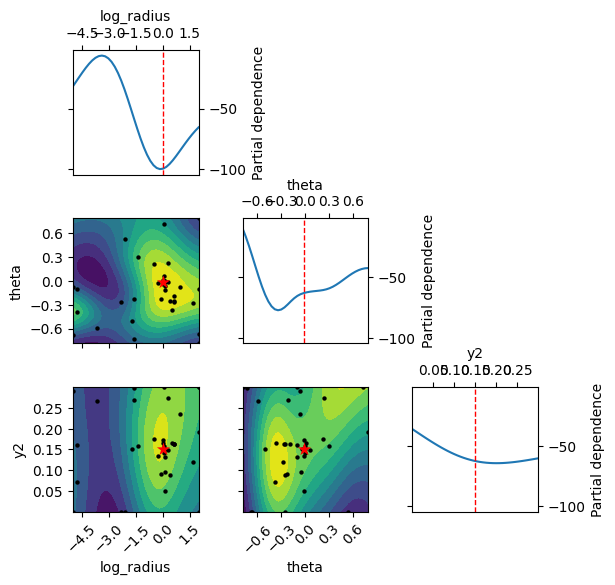

In [26]:
plot_objective(cr_gp1)

<Axes: >

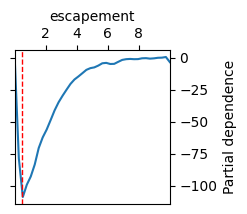

In [27]:
plot_objective(esc_gp1)

<Axes: >

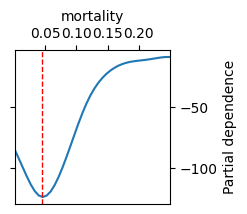

In [28]:
plot_objective(msy_gp1)

### 2

<Axes: >

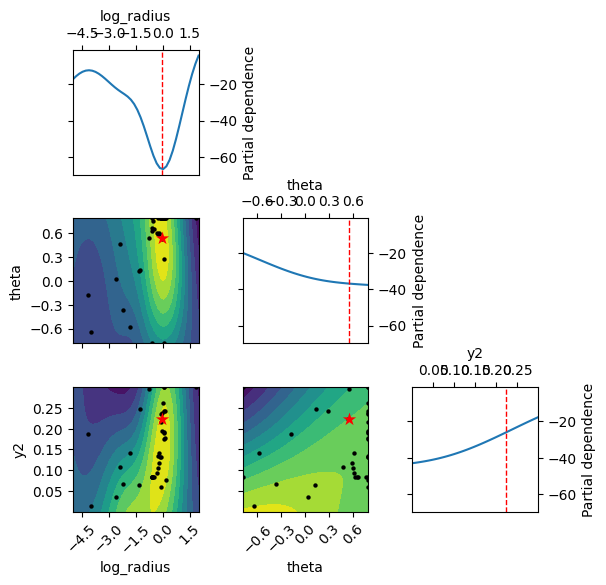

In [29]:
plot_objective(cr_gp2)

<Axes: >

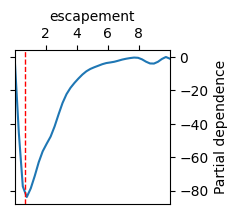

In [30]:
plot_objective(esc_gp2)

<Axes: >

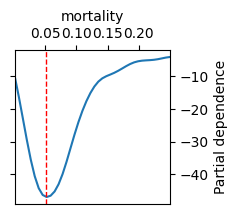

In [31]:
plot_objective(msy_gp2)

### 3

<Axes: >

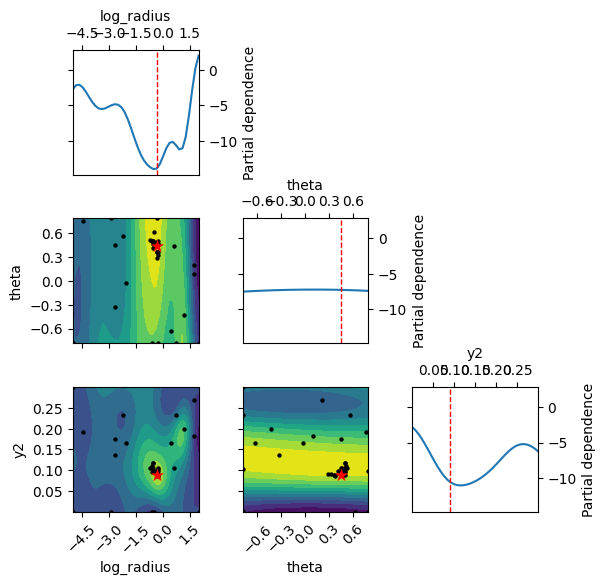

In [32]:
plot_objective(cr_gp3)

<Axes: >

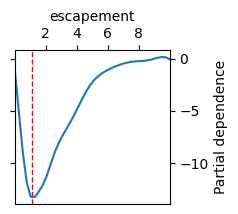

In [33]:
plot_objective(esc_gp3)

<Axes: >

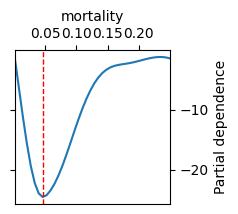

In [34]:
plot_objective(msy_gp3)

## Constant action on escapement env 
(Should be equivalent to simply constant escapement)

In [6]:
from rl4fisheries import AsmEnvEsc

# do this for CONFIG3
CONFIG = CONFIG3

def const_act_esc_obj(x):
    eval_env = AsmEnvEsc(config=CONFIG)
    agent = ConstAct(env=eval_env, action=np.float32([x[0]]))
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnvEsc, config=CONFIG, 
        n_batches=1, batch_size=200
    )
    return -np.mean(rews)

In [7]:
esc_gp2 = gp_minimize(const_act_esc_obj, [(-1.,1.)], n_calls = NCALLS, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


2024-05-24 22:49:09,759	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.7871
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.


2024-05-24 22:49:17,359	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.5012
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 3 started. Evaluating function at random point.


2024-05-24 22:49:24,880	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.7451
Function value obtained: -0.2427
Current minimum: -0.2427
Iteration No: 4 started. Evaluating function at random point.


2024-05-24 22:49:32,646	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.3741
Function value obtained: -0.0000
Current minimum: -0.2427
Iteration No: 5 started. Evaluating function at random point.


2024-05-24 22:49:41,032	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.5954
Function value obtained: -14.2442
Current minimum: -14.2442
Iteration No: 6 started. Evaluating function at random point.


2024-05-24 22:49:48,614	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.7939
Function value obtained: -0.0000
Current minimum: -14.2442
Iteration No: 7 started. Evaluating function at random point.


2024-05-24 22:49:56,376	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.8183
Function value obtained: -0.0000
Current minimum: -14.2442
Iteration No: 8 started. Evaluating function at random point.


2024-05-24 22:50:04,221	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 8.2861
Function value obtained: -13.5701
Current minimum: -14.2442
Iteration No: 9 started. Evaluating function at random point.


2024-05-24 22:50:12,548	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 7.7770
Function value obtained: -0.0000
Current minimum: -14.2442
Iteration No: 10 started. Evaluating function at random point.


2024-05-24 22:50:20,324	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.7843
Function value obtained: -0.0000
Current minimum: -14.2442
Iteration No: 11 started. Searching for the next optimal point.


2024-05-24 22:50:28,088	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.0924
Function value obtained: -0.8730
Current minimum: -14.2442
Iteration No: 12 started. Searching for the next optimal point.


2024-05-24 22:50:36,165	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.9161
Function value obtained: -13.7361
Current minimum: -14.2442
Iteration No: 13 started. Searching for the next optimal point.


2024-05-24 22:50:44,129	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.0523
Function value obtained: -13.9624
Current minimum: -14.2442
Iteration No: 14 started. Searching for the next optimal point.


2024-05-24 22:50:53,204	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 8.6467
Function value obtained: -14.4321
Current minimum: -14.4321
Iteration No: 15 started. Searching for the next optimal point.


2024-05-24 22:51:01,902	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 8.7355
Function value obtained: -9.5334
Current minimum: -14.4321
Iteration No: 16 started. Searching for the next optimal point.


2024-05-24 22:51:10,570	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.9293
Function value obtained: -3.9556
Current minimum: -14.4321
Iteration No: 17 started. Searching for the next optimal point.


2024-05-24 22:51:18,507	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.0527
Function value obtained: -0.0000
Current minimum: -14.4321
Iteration No: 18 started. Searching for the next optimal point.


2024-05-24 22:51:26,652	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.0973
Function value obtained: -0.0135
Current minimum: -14.4321
Iteration No: 19 started. Searching for the next optimal point.


2024-05-24 22:51:34,749	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 8.8475
Function value obtained: -0.0000
Current minimum: -14.4321
Iteration No: 20 started. Searching for the next optimal point.


2024-05-24 22:51:43,493	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.6437
Function value obtained: -13.9815
Current minimum: -14.4321
Iteration No: 21 started. Searching for the next optimal point.


2024-05-24 22:51:52,155	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 8.1441
Function value obtained: -0.0000
Current minimum: -14.4321
Iteration No: 22 started. Searching for the next optimal point.


2024-05-24 22:52:00,312	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.5943
Function value obtained: -0.0000
Current minimum: -14.4321
Iteration No: 23 started. Searching for the next optimal point.


2024-05-24 22:52:08,915	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.1905
Function value obtained: -13.9271
Current minimum: -14.4321
Iteration No: 24 started. Searching for the next optimal point.


2024-05-24 22:52:17,098	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 8.8385
Function value obtained: -13.3206
Current minimum: -14.4321
Iteration No: 25 started. Searching for the next optimal point.


2024-05-24 22:52:25,965	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 8.7661
Function value obtained: -13.6458
Current minimum: -14.4321
Iteration No: 26 started. Searching for the next optimal point.


2024-05-24 22:52:34,730	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.7579
Function value obtained: -13.8530
Current minimum: -14.4321
Iteration No: 27 started. Searching for the next optimal point.


2024-05-24 22:52:43,478	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.6986
Function value obtained: -14.1390
Current minimum: -14.4321
Iteration No: 28 started. Searching for the next optimal point.


2024-05-24 22:52:52,188	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 8.7337
Function value obtained: -14.7883
Current minimum: -14.7883
Iteration No: 29 started. Searching for the next optimal point.


2024-05-24 22:53:00,945	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 8.4861
Function value obtained: -13.6805
Current minimum: -14.7883
Iteration No: 30 started. Searching for the next optimal point.


2024-05-24 22:53:09,425	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 9.1717
Function value obtained: -14.0910
Current minimum: -14.7883
Iteration No: 31 started. Searching for the next optimal point.


2024-05-24 22:53:18,584	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 8.6759
Function value obtained: -13.8217
Current minimum: -14.7883
Iteration No: 32 started. Searching for the next optimal point.


2024-05-24 22:53:27,310	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 8.8683
Function value obtained: -13.4420
Current minimum: -14.7883
Iteration No: 33 started. Searching for the next optimal point.


2024-05-24 22:53:36,166	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 8.6232
Function value obtained: -14.0526
Current minimum: -14.7883
Iteration No: 34 started. Searching for the next optimal point.


2024-05-24 22:53:44,792	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 8.6967
Function value obtained: -14.3145
Current minimum: -14.7883
Iteration No: 35 started. Searching for the next optimal point.


2024-05-24 22:53:53,525	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 8.8980
Function value obtained: -14.2506
Current minimum: -14.7883
Iteration No: 36 started. Searching for the next optimal point.


2024-05-24 22:54:02,380	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 8.8348
Function value obtained: -13.8238
Current minimum: -14.7883
Iteration No: 37 started. Searching for the next optimal point.


2024-05-24 22:54:11,253	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 8.9657
Function value obtained: -14.5724
Current minimum: -14.7883
Iteration No: 38 started. Searching for the next optimal point.


2024-05-24 22:54:20,220	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 9.1209
Function value obtained: -13.9084
Current minimum: -14.7883
Iteration No: 39 started. Searching for the next optimal point.


2024-05-24 22:54:29,333	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 8.8265
Function value obtained: -14.1652
Current minimum: -14.7883
Iteration No: 40 started. Searching for the next optimal point.


2024-05-24 22:54:38,131	INFO worker.py:1749 -- Started a local Ray instance.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 8.1129
Function value obtained: -14.0068
Current minimum: -14.7883


In [8]:
esc_gp2.x, esc_gp2.fun

([-0.9388866114029923], -14.788338827246875)

In [9]:
ca_agent = ConstAct(env=AsmEnvEsc(config=CONFIG), action=esc_gp2.x[0])

In [10]:
ca_agent.action_to_escapement(ca_agent.action)

1.5278347149251914